<a href="https://colab.research.google.com/github/saponew/James-Bond/blob/main/Random_Forest_Bond_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier

In [4]:
# Set path to CSV
data = Path('/content/drive/MyDrive/Bootcamp/Project_2/Data/Data tables/all_cusips_core_rating_shifted_df_v4_MACRO_FINAL.csv')
df = pd.read_csv(data)
print(df.info)
print(df.columns)
df.head(10)

<bound method DataFrame.info of        Unnamed: 0  ...  index_fred_macro_vix
0               0  ...                 30.85
1               1  ...                 25.02
2               2  ...                 24.40
3               3  ...                 23.43
4               4  ...                 23.43
...           ...  ...                   ...
41043       41043  ...                 19.61
41044       41044  ...                 19.61
41045       41045  ...                 19.61
41046       41046  ...                 19.61
41047       41047  ...                 19.40

[41048 rows x 60 columns]>
Index(['Unnamed: 0', 'Unnamed: 0.1', 'date_fundamentals', 'cusip_company_part',
       'siccode_fundamentals', 'ticker_fundamentals',
       'company_name_fundamentals', 'revenueusd', 'ebitdausd', 'ebitdamargin',
       'netinccmnusd', 'netmargin', 'cashnequsd', 'workingcapital', 'debtusd',
       'liabilities', 'equityusd', 'marketcap', 'ev', 'fcf', 'ncfdebt',
       'currentratio', 'de', 'divyie

,Unnamed: 0,Unnamed: 0.1,date_fundamentals,cusip_company_part,siccode_fundamentals,ticker_fundamentals,company_name_fundamentals,revenueusd,ebitdausd,ebitdamargin,netinccmnusd,netmargin,cashnequsd,workingcapital,debtusd,liabilities,equityusd,marketcap,ev,fcf,ncfdebt,currentratio,de,divyield,epsusd,payoutratio,evebitda,pb,pe,isin,currency,close_edi,mktclosedate,secid,uscode,coupon_x,maturity_date,timedelta,cusip,maturity,rating,date,coupon_y,issuer_cusip,rank,timedelta_2,date_fundamentals_shifted,rating_shifted,rank_shifted,rank_diff,maturity_year,rank_change,rank_change_2,observed_date,percent_fred_macro_yc_30_yr,percent_fred_macro_yc_3_mo,percentchange_fred_macro_gdp,dollars_fred_crude_oil_prices,percent_fred_five_year_breakeven_inflation,index_fred_macro_vix
0,0,0.0,2009-07-08,767754,5912,RAD,Rite Aid Corp,6.531178e+09,1.545970e+08,0.024,-98471000.0,-0.015,1.364590e+08,1.792586e+09,5.691324e+09,9.309811e+09,-1.290631e+09,1.159302e+09,6.714167e+09,315294016.0,-3.104920e+08,1.749,-7.213,0.000,-2.20,0.000,-4.539000,-0.898,-0.404,US767754AD64,USD,68.500,2009-06-19,681831.0,767754AD6,6.875%,2013-08-15,19,767754AD6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-06,NaN,NaN,NaN,4.107,NaN,NaN,2009-07-08,4.35,0.19,1.1,60.15,1.12,30.85
1,1,0.0,2009-07-15,001765,4512,AAMRQ,Amr Corp,4.889000e+09,-2.230000e+08,-0.046,-390000000.0,-0.080,6.510000e+08,-3.130000e+09,1.009200e+10,2.713800e+10,-3.000000e+09,1.220332e+09,1.066133e+10,48000000.0,-1.080000e+08,0.622,-9.046,0.000,-1.39,0.000,12.157000,-0.407,-1.151,US001765AU07,USD,64.000,2009-07-15,832734.0,001765AU0,9%,2012-08-01,0,001765AU0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-17,NaN,NaN,NaN,3.049,NaN,NaN,2009-07-15,4.25,0.18,1.1,61.49,1.27,25.02
2,2,0.0,2009-07-21,895953,5812,YUM,Yum Brands Inc,2.476000e+09,5.200000e+08,0.210,303000000.0,0.122,2.840000e+08,-4.810000e+08,3.548000e+09,6.367000e+09,4.760000e+08,1.557371e+10,1.883771e+10,6000000.0,9.000000e+06,0.690,13.376,0.023,0.65,0.292,9.145000,32.718,15.465,US895953AD96,USD,110.064,2009-07-21,682971.0,895953AD9,8.875%,2011-04-15,0,895953AD9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-17,NaN,NaN,NaN,1.734,NaN,NaN,2009-07-21,4.53,0.17,1.1,64.81,1.33,24.40
3,3,0.0,2009-07-24,693304,4931,EXC,Exelon Corp,4.141000e+09,1.898000e+09,0.458,657000000.0,0.159,1.884000e+09,1.659000e+09,1.288200e+10,3.673900e+10,1.215300e+10,3.588031e+10,4.687831e+10,365000000.0,-2.780000e+08,1.398,3.023,0.038,1.00,0.525,6.347000,2.952,12.925,US693304AB36,USD,108.312,2009-07-24,257507.0,693304AB3,5.95%,2011-11-01,0,693304AB3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-05,NaN,NaN,NaN,2.274,NaN,NaN,2009-07-24,4.45,0.19,1.1,66.96,1.39,23.43
4,4,0.0,2009-07-24,693304,4931,EXC,Exelon Corp,4.141000e+09,1.898000e+09,0.458,657000000.0,0.159,1.884000e+09,1.659000e+09,1.288200e+10,3.673900e+10,1.215300e+10,3.588031e+10,4.687831e+10,365000000.0,-2.780000e+08,1.398,3.023,0.038,1.00,0.525,6.347000,2.952,12.925,US693304AD91,USD,104.972,2009-07-24,257512.0,693304AD9,4.75%,2012-10-01,0,693304AD9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-05,NaN,NaN,NaN,3.192,NaN,NaN,2009-07-24,4.45,0.19,1.1,66.96,1.39,23.43
5,5,0.0,2009-07-31,665772,4931,XEL,Xcel Energy Inc,2.016083e+09,5.280670e+08,0.262,116046992.0,0.058,3.802530e+08,7.394000e+06,8.884389e+09,1.791353e+10,7.073723e+09,9.087161e+09,1.759130e+10,-156418000.0,3.258160e+08,1.003,2.532,0.048,0.25,0.980,7.146000,1.285,13.486,US665772BW80,USD,114.000,2009-07-31,961125.0,665772BW8,8%,2012-08-28,0,665772BW8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-26,NaN,NaN,NaN,3.079,NaN,NaN,2009-07-31,4.50,0.19,1.1,69.26,1.32,25.40
6,6,0.0,2009-07-31,854616,3420,SWK,Stanley Black & Decker Inc,9.191999e+08,1.613000e+08,0.175,69500000.0,0.076,1.563000e+08,2.576000e+08,1.548300e+09,2.929800e+09,1.795700e+09,3.186122e+09,4.578122e+09,43000000.0,-5.700000e+06,1.230,1.632,0.032,0.88,0.364,7.488000,1.774,11.675,US854616AP49,USD,68.850,2009-07-31,1263850.0,854616AP4,5.902%,2045-12-01,0,854616AP4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-22,NaN,NaN,NaN,36.362,NaN,NaN,2009-07-31,4.50,0.19,1.1,69.26,1.32,25.40
7,7,

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data wrangling: drop NaN, cap timedelta @60, convert format 'coupon' column
df_final = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df_final.dropna(inplace=True)
df_final = df_final.loc[df_final['timedelta'] <= 60]
df_final['coupon_x'].replace('%', '', regex=True, inplace=True)
df_final['coupon_x'] = df_final['coupon_x'].astype('float') / 100

print(df_final.info)
df_final.head()

<bound method DataFrame.info of       date_fundamentals  ... index_fred_macro_vix
570          2012-06-27  ...                20.38
571          2012-06-27  ...                20.38
581          2012-07-05  ...                16.66
587          2012-07-19  ...                16.16
588          2012-07-19  ...                16.16
...                 ...  ...                  ...
40084        2020-12-18  ...                21.93
40090        2020-12-18  ...                21.93
40093        2020-12-18  ...                21.93
40098        2020-12-18  ...                21.93
40325        2021-02-12  ...                21.25

[13498 rows x 58 columns]>


,date_fundamentals,cusip_company_part,siccode_fundamentals,ticker_fundamentals,company_name_fundamentals,revenueusd,ebitdausd,ebitdamargin,netinccmnusd,netmargin,cashnequsd,workingcapital,debtusd,liabilities,equityusd,marketcap,ev,fcf,ncfdebt,currentratio,de,divyield,epsusd,payoutratio,evebitda,pb,pe,isin,currency,close_edi,mktclosedate,secid,uscode,coupon_x,maturity_date,timedelta,cusip,maturity,rating,date,coupon_y,issuer_cusip,rank,timedelta_2,date_fundamentals_shifted,rating_shifted,rank_shifted,rank_diff,maturity_year,rank_change,rank_change_2,observed_date,percent_fred_macro_yc_30_yr,percent_fred_macro_yc_3_mo,percentchange_fred_macro_gdp,dollars_fred_crude_oil_prices,percent_fred_five_year_breakeven_inflation,index_fred_macro_vix
570,2012-06-27,00724F,7372,ADBE,Adobe Inc,1.124449e+09,3.883770e+08,0.345,223876016.0,0.199,951238080.0,2.525163e+09,1.510094e+09,3.266186e+09,6.099646e+09,1.544626e+10,1.600512e+10,387451008.0,-2290000.0,3.027,0.535,0.000,0.45,0.000,11.385,2.532,19.856001,US00724FAA93,USD,105.124,2012-06-27,1758557.0,00724FAA9,0.03250,2015-02-01,0,00724FAA9,2015-02-01,BAA1,2012-06-15,3.250,00724F,8.0,12.0,2013-01-22,BAA1,8.0,0.0,2.600,0.0,0.0,2012-06-27,2.71,0.10,2.9,79.34,1.68,20.38
571,2012-06-27,00724F,7372,ADBE,Adobe Inc,1.124449e+09,3.883770e+08,0.345,223876016.0,0.199,951238080.0,2.525163e+09,1.510094e+09,3.266186e+09,6.099646e+09,1.544626e+10,1.600512e+10,387451008.0,-2290000.0,3.027,0.535,0.000,0.45,0.000,11.385,2.532,19.856001,US00724FAB76,USD,111.915,2012-06-27,1758481.0,00724FAB7,0.04750,2020-02-01,0,00724FAB7,2020-02-01,BAA1,2012-06-15,4.750,00724F,8.0,12.0,2013-01-22,BAA1,8.0,0.0,7.603,0.0,0.0,2012-06-27,2.71,0.10,2.9,79.34,1.68,20.38
581,2012-07-05,026375,2771,AM1,American Greetings Corp,3.931060e+08,2.626500e+07,0.067,7250000.5,0.018,60180000.0,2.500000e+08,2.251810e+08,8.090370e+08,6.794340e+08,4.851067e+08,6.501076e+08,33485000.0,0.0,1.842,1.191,0.052,0.20,0.750,4.348,0.714,15.229000,US026375AP03,USD,105.250,2012-07-05,3295358.0,026375AP0,0.07375,2021-12-01,0,026375AP0,2021-12-01,BA2,2012-06-15,7.375,026375,12.0,20.0,2013-01-02,BA2,12.0,0.0,9.414,0.0,0.0,2012-07-05,2.74,0.09,2.9,87.74,1.80,16.66
587,2012-07-19,05329W,5500,AN,Autonation Inc,3.904500e+09,1.833000e+08,0.047,78600000.0,0.020,62100000.0,1.686000e+08,2.028500e+09,4.933200e+09,1.528200e+09,4.922053e+09,6.888453e+09,-13500000.0,144500000.0,1.062,3.228,0.000,0.65,0.000,10.145,3.221,16.874001,US05329WAJ18,USD,110.152,2012-07-19,1856738.0,05329WAJ1,0.06750,2018-04-15,0,05329WAJ1,2018-04-15,BA2,2012-06-15,6.750,05329W,12.0,34.0,2013-02-15,BA2,12.0,0.0,5.742,0.0,0.0,2012-07-19,2.59,0.09,2.9,89.07,1.82,16.16
588,2012-07-19,126408,4011,CSX,Csx Corp,3.012000e+09,1.211000e+09,0.402,512000000.0,0.170,642000000.0,-2.030000e+08,9.089000e+09,2.069400e+10,8.895000e+09,2.369094e+10,3.213794e+10,93000000.0,-42000000.0,0.921,2.326,0.022,0.49,0.286,7.062,2.663,12.588000,US126408BP76,USD,127.500,2012-07-19,1070939.0,126408BP7,0.07250,2027-05-01,0,126408BP7,2027-05-01,BAA3,2012-06-15,7.250,126408,10.0,34.0,2013-02-19,BAA2,9.0,1.0,14.792,1.0,1.0,2012-07-19,2.59,0.09,2.9,89.07,1.82,16.16


In [6]:
# Set x variable list of features
x_var_list = ['siccode_fundamentals', 'revenueusd', 'ebitdausd',
       'ebitdamargin', 'netinccmnusd', 'netmargin', 'cashnequsd',
       'workingcapital', 'debtusd', 'liabilities', 'equityusd', 'marketcap',
       'ev', 'fcf', 'ncfdebt', 'currentratio', 'de', 'divyield', 'epsusd',
       'payoutratio', 'evebitda', 'pb', 'pe', 'close_edi', 'coupon_x',
       'percent_fred_macro_yc_30_yr',
       'percent_fred_macro_yc_3_mo', 'percentchange_fred_macro_gdp',
       'dollars_fred_crude_oil_prices',
       'percent_fred_five_year_breakeven_inflation', 'index_fred_macro_vix', 'maturity_year']

In [7]:
# Assign x and target features
X = df_final[x_var_list]
y = df_final['rank_change']

Counter(y)

Counter({-1.0: 584, 0.0: 12470, 1.0: 444})

In [8]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=78)

In [9]:
np.unique(y_train, return_counts = True)

(array([-1.,  0.,  1.]), array([ 431, 9360,  332]))

In [10]:
y_test[:10]

27129    0.0
17435    0.0
15496    0.0
1173     0.0
31794    0.0
5468     0.0
23607    0.0
15022   -1.0
12763    0.0
38402    0.0
Name: rank_change, dtype: float64

In [11]:
# Creating the scaler instance
scaler = StandardScaler()

# Fitting the scaler
scaler.fit(X_train)

# Transforming the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Create a random forest classifier
sqrt_features = int(np.sqrt(len(x_var_list)))

rf_model = RandomForestClassifier(max_samples = None, 
                                  max_features = sqrt_features,
                                  n_estimators = 100,
                                  max_depth=5,
                                  random_state=0)

# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = rf_model.predict(X_test_scaled)
print(np.unique(predictions))
print(np.unique(y_test))

[-1.  0.]
[-1.  0.  1.]


In [13]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual -1", "Actual 0", "Actual +1"], 
               columns=["Pred -1","Pred 0", "Pred 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [14]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Pred -1,Pred 0,Pred 1
Actual -1,30,123,0
Actual 0,6,3104,0
Actual +1,0,112,0


Accuracy Score : 0.9285925925925926
Classification Report
              precision    recall  f1-score   support

        -1.0       0.83      0.20      0.32       153
         0.0       0.93      1.00      0.96      3110
         1.0       0.00      0.00      0.00       112

    accuracy                           0.93      3375
   macro avg       0.59      0.40      0.43      3375
weighted avg       0.89      0.93      0.90      3375



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print("Balanced accuracy score: %.4f" % balanced_accuracy_score(y_test, predictions))

Balanced accuracy score: 0.3980


In [16]:
# Get the feature importance array
importances = rf_model.feature_importances_

In [17]:
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.09518062616852144, 'cashnequsd'),
 (0.07659564156772912, 'pe'),
 (0.07357510954418692, 'marketcap'),
 (0.0519439791599483, 'percent_fred_macro_yc_30_yr'),
 (0.05168070796462883, 'close_edi'),
 (0.04369888222987587, 'siccode_fundamentals'),
 (0.042125137683599496, 'netinccmnusd'),
 (0.04019267634163654, 'ev'),
 (0.03887989075549197, 'evebitda'),
 (0.03883548987397109, 'equityusd')]

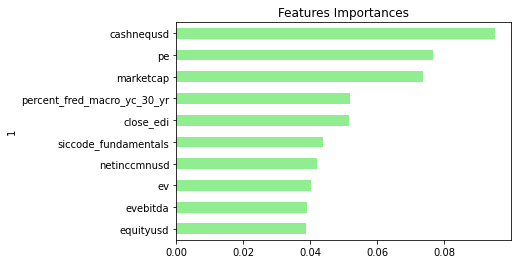

In [19]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_df[:10].plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False).invert_yaxis()

In [20]:
# RANDOM OVERSAMPLING
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({-1.0: 9360, 0.0: 9360, 1.0: 9360})

In [21]:
# Create a random forest classifier
rf_ro_model = RandomForestClassifier(max_samples = None, 
                                     max_features = sqrt_features,
                                     n_estimators = 100,
                                     max_depth=5,
                                     random_state=0)

# Fit the model
rf_ro_model = rf_ro_model.fit(X_resampled, y_resampled)

# Make a prediction of "y" values from the X_test dataset
predictions = rf_ro_model.predict(X_test_scaled)

In [22]:
# Display the confusion matrix
y_pred = rf_ro_model.predict(X_test_scaled)
confusion_matrix(y_test, y_pred)

array([[ 126,   26,    1],
       [ 351, 2469,  290],
       [   1,   17,   94]])

In [23]:
# Print balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8189019337638593

In [24]:
# Print classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

        -1.0       0.26      0.82      0.40       153
         0.0       0.98      0.79      0.88      3110
         1.0       0.24      0.84      0.38       112

    accuracy                           0.80      3375
   macro avg       0.50      0.82      0.55      3375
weighted avg       0.93      0.80      0.84      3375



In [25]:
# Get the feature importance array
importances = rf_ro_model.feature_importances_

In [26]:
# List the top 10 most important features
importances_sorted = sorted(zip(rf_ro_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.1403457488389676, 'pe'),
 (0.08793417062901196, 'evebitda'),
 (0.07814896463869903, 'percent_fred_macro_yc_30_yr'),
 (0.04989869940357998, 'pb'),
 (0.04080280460861385, 'equityusd'),
 (0.04051774856843325, 'marketcap'),
 (0.039332739756651365, 'netmargin'),
 (0.036378952850707975, 'debtusd'),
 (0.036160237302014925, 'percent_fred_macro_yc_3_mo'),
 (0.034812742028891695, 'ev')]

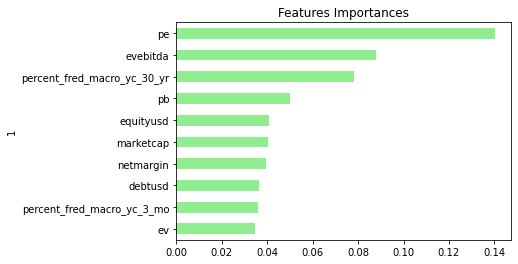

In [27]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_ro_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_df[:10].plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False).invert_yaxis()

In [ ]:
# PRECISION RECALL CURVE

In [28]:
from sklearn.metrics import precision_recall_curve

probs_lr = rf_model.predict_proba(X_test)[:, 1]
probs_rf = rf_ro_model.predict_proba(X_test)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, probs_lr, pos_label=1)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, probs_rf, pos_label=1)

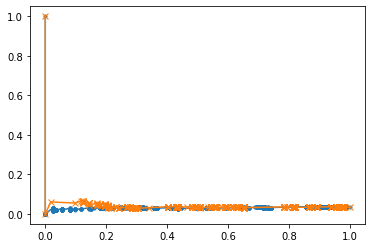

In [29]:
plt.plot(recall_lr, precision_lr, marker='.')
plt.plot(recall_rf, precision_rf, marker='x')

In [30]:
# SMOTE OVERSAMPLING
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy= {-1:10000, 0:10000, 1:10000}).fit_resample(
    X_train_scaled, y_train)

Counter(y_resampled)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (10000) in class -1 will be larger than the number of samples in the majority class (class #0.0 -> 9360)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (10000) in class 0 will be larger than the number of samples in the majority class (class #0.0 -> 9360)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (10000) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 9360)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, c

Counter({-1.0: 10000, 0.0: 10000, 1.0: 10000})

In [31]:
# Create a random forest classifier
rf_model_SM = RandomForestClassifier(max_samples = None, 
                                     max_features = sqrt_features,
                                     n_estimators = 100,
                                     max_depth=5,
                                     random_state=0)

# Fit the model
rf_model_SM = rf_model_SM.fit(X_resampled, y_resampled)

# Make a prediction of "y" values from the X_test dataset
predictions = rf_model_SM.predict(X_test_scaled)

In [32]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual -1", "Actual 0", "Actual +1"], 
               columns=["Pred -1","Pred 0", "Pred 1"])

acc_score = accuracy_score(y_test, predictions)

In [33]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Pred -1,Pred 0,Pred 1
Actual -1,123,29,1
Actual 0,365,2409,336
Actual +1,2,20,90


Accuracy Score : 0.7768888888888889
Classification Report
              precision    recall  f1-score   support

        -1.0       0.25      0.80      0.38       153
         0.0       0.98      0.77      0.87      3110
         1.0       0.21      0.80      0.33       112

    accuracy                           0.78      3375
   macro avg       0.48      0.79      0.53      3375
weighted avg       0.92      0.78      0.83      3375



In [34]:
# Balanced accuracy score
print("Balanced accuracy score: %.4f" % balanced_accuracy_score(y_test, predictions))

Balanced accuracy score: 0.7940


In [35]:
# Get the feature importance array
importances = rf_model_SM.feature_importances_

In [36]:
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model_SM.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.13105228828311002, 'pe'),
 (0.10395099730641942, 'evebitda'),
 (0.08416693717264982, 'percent_fred_macro_yc_30_yr'),
 (0.045825208431497705, 'netmargin'),
 (0.04177028116137459, 'pb'),
 (0.0380512918339089, 'debtusd'),
 (0.03794769399141453, 'percent_fred_macro_yc_3_mo'),
 (0.03685239830712696, 'equityusd'),
 (0.0367105072133036, 'ev'),
 (0.034985550971327405, 'percentchange_fred_macro_gdp')]

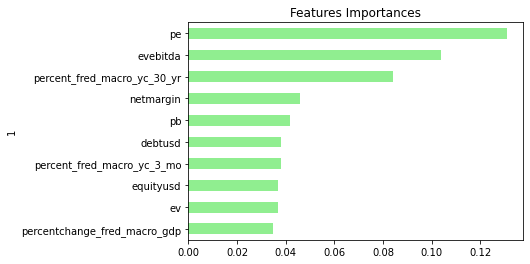

In [37]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model_SM.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_df[:10].plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False).invert_yaxis()

In [38]:
#SMOTEENN combination sampling
sm = SMOTEENN(random_state=1)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({-1.0: 9339, 0.0: 8372, 1.0: 9345})

In [39]:
# Create a random forest classifier
rf_model_SO = RandomForestClassifier(max_samples = None, 
                                     max_features = sqrt_features,
                                     n_estimators = 100,
                                     max_depth=5,
                                     random_state=0)

# Fit the model
rf_model_SO = rf_model_SO.fit(X_resampled, y_resampled)

# Make a prediction of "y" values from the X_test dataset
predictions = rf_model_SO.predict(X_test_scaled)

In [40]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual -1", "Actual 0", "Actual +1"], 
               columns=["Pred -1","Pred 0", "Pred 1"])

acc_score = accuracy_score(y_test, predictions)

In [41]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Pred -1,Pred 0,Pred 1
Actual -1,126,25,2
Actual 0,462,2254,394
Actual +1,8,11,93


Accuracy Score : 0.7327407407407407
Classification Report
              precision    recall  f1-score   support

        -1.0       0.21      0.82      0.34       153
         0.0       0.98      0.72      0.83      3110
         1.0       0.19      0.83      0.31       112

    accuracy                           0.73      3375
   macro avg       0.46      0.79      0.49      3375
weighted avg       0.92      0.73      0.79      3375



In [42]:
# Balanced accuracy score
print("Balanced accuracy score: %.4f" % balanced_accuracy_score(y_test, predictions))

Balanced accuracy score: 0.7929


In [43]:
# Get the feature importance array
importances = rf_model_SO.feature_importances_

In [44]:
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model_SO.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.1441925056905273, 'pe'),
 (0.0976802589441564, 'evebitda'),
 (0.09479990303638709, 'percent_fred_macro_yc_30_yr'),
 (0.042176541428613365, 'netmargin'),
 (0.03678492282953559, 'siccode_fundamentals'),
 (0.03619393710383872, 'percentchange_fred_macro_gdp'),
 (0.035598919505607216, 'marketcap'),
 (0.03498308133291789, 'ev'),
 (0.03370920623210007, 'pb'),
 (0.03312123220181769, 'percent_fred_macro_yc_3_mo')]

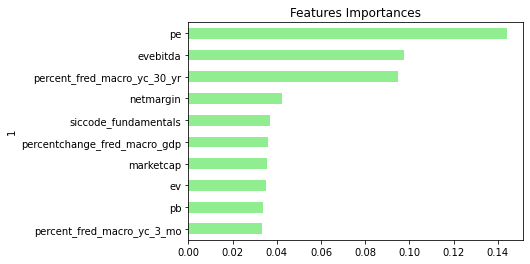

In [45]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model_SO.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_df[:10].plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False).invert_yaxis()